In [3]:
%%time

from utils.utils import create_dataset, Trainer
from layer.layer import Embedding, FeaturesEmbedding, EmbeddingsInteraction, MultiLayerPerceptron

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Training on [{}].'.format(device))


Training on [cuda:0].
CPU times: user 640 ms, sys: 265 ms, total: 906 ms
Wall time: 2.16 s


In [4]:
%%time

dataset = create_dataset('criteo', sample_num=100000, device=device)
field_dims, (train_X, train_y), (valid_X, valid_y), (test_X, test_y) = dataset.train_valid_test_split()


CPU times: user 6.98 s, sys: 1.09 s, total: 8.06 s
Wall time: 10.5 s


In [5]:
class ResidualUnit(nn.Module):
    
    def __init__(self, input_size):
        super(ResidualUnit, self).__init__()
        
        self.fc1 = nn.Linear(input_size, input_size)
        self.fc2 = nn.Linear(input_size, input_size)
        
    def forward(self, x):
        output = self.fc1(x)
        output = torch.relu(output)
        output = self.fc2(x)
        output = output + x
        return output


class DeepCrossing(nn.Module):
    
    def __init__(self, field_dims, embed_dim=4, num_res=1):
        super(DeepCrossing, self).__init__()
        
        input_size = len(field_dims) * embed_dim
        self.res = nn.Sequential(*[ResidualUnit(input_size) for _ in range(num_res)])
        self.embed = FeaturesEmbedding(field_dims, embed_dim)
        self.fc = nn.Linear(input_size, 1)
        
    def forward(self, x):
        # x shape: (batch_size, num_fields)
        x = self.embed(x)
        x = x.reshape(x.shape[0], -1)
        x = self.res(x)
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x


 17%|█▋        | 103/600 [00:20<01:38,  5.04it/s]


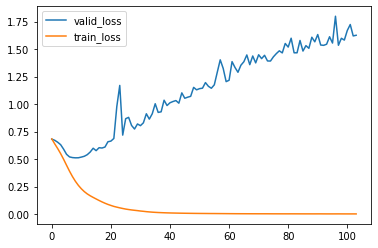

train_loss: 0.61846 | train_metric: 0.92215
valid_loss: 0.63032 | valid_metric: 0.74055
test_loss:  0.62800 | test_auc:  0.74838
CPU times: user 20 s, sys: 255 ms, total: 20.2 s
Wall time: 20.8 s


In [6]:
%%time

EMBEDDING_DIM = 8
LEARNING_RATE = 1e-4
REGULARIZATION = 1e-6
BATCH_SIZE = 4096
EPOCH = 600
TRIAL = 100

dc = DeepCrossing(field_dims, EMBEDDING_DIM).to(device)
optimizer = optim.Adam(dc.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION)
criterion = nn.BCELoss()

trainer = Trainer(dc, optimizer, criterion, BATCH_SIZE)
trainer.train(train_X, train_y, epoch=EPOCH, trials=TRIAL, valid_X=valid_X, valid_y=valid_y)
test_loss, test_auc = trainer.test(test_X, test_y)
print('test_loss:  {:.5f} | test_auc:  {:.5f}'.format(test_loss, test_auc))
